# Split domain into 5 regions for like-for-like comparison between MCS shield/core and cloud shield/core (and env)

In [1]:
import datetime as dt
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe

from mcs_prime import PATHS, McsTracks

In [2]:
tracks = tracks = McsTracks.open(PATHS['statsdir'] / 'mcs_tracks_final_extc_20190101.0000_20200101.0000.nc', 
                                 PATHS['pixeldir'])
tracks

McsTracks[2019-01-01 00:30:00, 2019-12-31 22:30:00, ntracks=32843]

In [3]:
time = dt.datetime(2019, 1, 5, 0, 30)
pdtime = pd.Timestamp(time)

In [4]:
ts = tracks.tracks_at_time(time)
frame = ts.pixel_data.get_frame(time)
tmask = (ts.dstracks.base_time == pdtime).values
cns = ts.dstracks.cloudnumber.values[tmask]
cns.sort()

In [5]:
frame

In [6]:
dspixel = frame.dspixel
dspixel

<xarray.Dataset>
Dimensions:                        (time: 1, lat: 1200, lon: 3600)
Coordinates:
  * time                           (time) datetime64[ns] 2019-01-05T00:30:00....
  * lat                            (lat) float32 -59.95 -59.85 ... 59.85 59.95
  * lon                            (lon) float32 -179.9 -179.9 ... 179.9 179.9
Data variables:
    base_time                      (time) datetime64[ns] ...
    longitude                      (lat, lon) float32 ...
    latitude                       (lat, lon) float32 ...
    tb                             (time, lat, lon) float32 ...
    precipitation                  (time, lat, lon) float32 ...
    cloudtype                      (time, lat, lon) float64 ...
    cloudnumber                    (time, lat, lon) float64 ...
    split_tracknumbers             (time, lat, lon) float64 ...
    merge_tracknumbers             (time, lat, lon) float64 ...
    cloudtracknumber_nomergesplit  (time, lat, lon) float64 ...
    cloudtracknumber               (time, lat, lon) float64 ...
    pcptracknumber                 (time, lat, lon) float64 ...
Attributes:
    Title:                     Robust MCS pixel-level tracking data
    Contact:                   Zhe Feng: zhe.feng@pnnl.gov
    Created_on:                Fri Mar 18 17:11:47 2022
    startdate:                 20190101.0000
    enddate:                   20200101.0000
    precipitation_datasource:  imerg
    mcs_tb_area_thresh:        40000
    mcs_tb_duration_thresh:    4
    mcs_pf_majoraxis_thresh:   100
    mcs_pf_durationthresh:     4

In [7]:
dspixel.cloudnumber

<xarray.DataArray 'cloudnumber' (time: 1, lat: 1200, lon: 3600)>
[4320000 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2019-01-05T00:30:00.000013312
  * lat      (lat) float32 -59.95 -59.85 -59.75 -59.65 ... 59.75 59.85 59.95
  * lon      (lon) float32 -179.9 -179.9 -179.8 -179.6 ... 179.8 179.9 179.9
Attributes:
    long_name:  Labeled feature number for tracking
    units:      unitless

In [26]:
def contour(field, offset=0, **kwargs):
    plt.contour(dspixel.longitude, dspixel.latitude + offset, field, **kwargs)

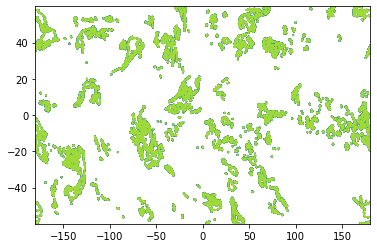

In [9]:
contour(dspixel.cloudnumber[0].values > 0)

In [15]:
def mask_contour(field, **kwargs):
    contour(field, levels=[0.5], **kwargs)

This produces a busy plot that lets you see link between MCSs (black), all tracked clouds (purple)
Tb < 241 (shield, green), Tb < 225 (core, red), and precip > 3 mm hr-1 (blue).
Precip > 3 mm hr-1 is smoothed (30 x 30 km window) before merging - Feng et al. 2021, p5.
Key points are: 
* tracked clouds include merged precip data - look at blue/purple in SW.
* not all Tb < 241 areas are tracked (NE green blobs not matched with purple)
* MCS must have cold cloud core (red in black NE of centre)

(0.0, 15.0)

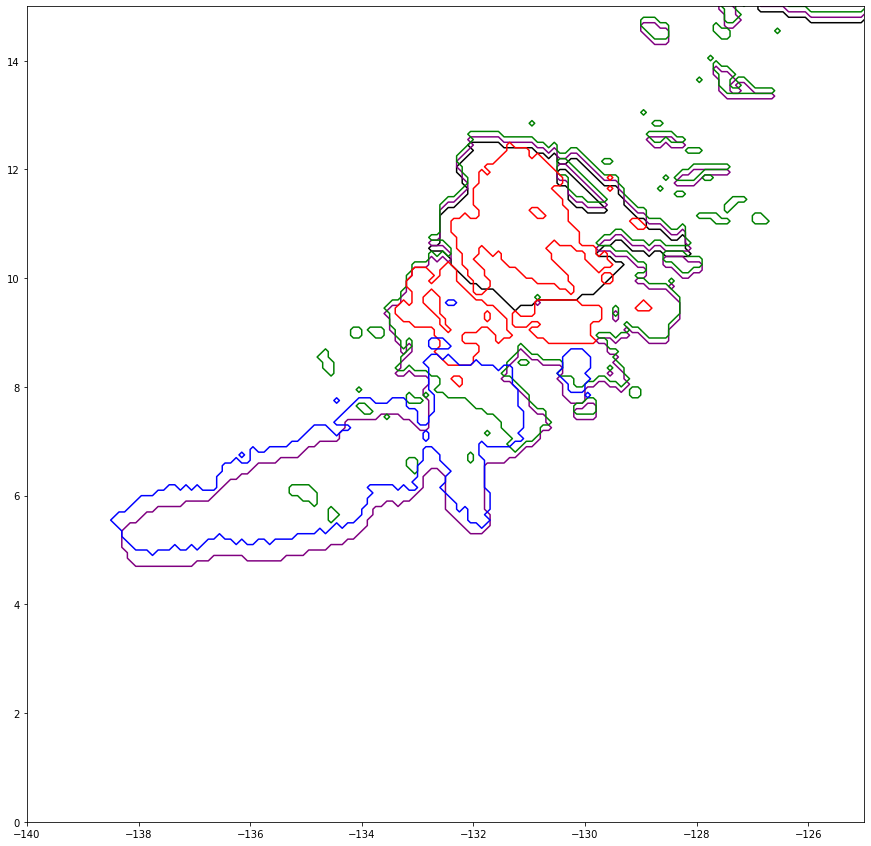

In [38]:
plt.figure(figsize=(15, 15))
mask_contour(dspixel.cloudnumber[0].isin(cns).values, offset=-0.1, colors='k')
mask_contour(dspixel.cloudnumber[0].values > 0, colors='purple')
mask_contour(dspixel.tb[0].values < 241, offset=0.1, colors='g')
mask_contour(dspixel.tb[0].values < 225, offset=0.2, colors='r')
mask_contour(dspixel.precipitation[0].values > 3, offset=0.3, colors='b')
plt.xlim((-140, -125))
plt.ylim((0, 15));

In [39]:
mcs_shield = dspixel.cloudnumber[0].isin(cns).values
mcs_core = mcs_shield & (dspixel.tb[0].values < 225)
cloud_shield = (dspixel.cloudnumber[0].values > 0) & ~mcs_shield
cloud_core = cloud_shield & (dspixel.tb[0].values < 225)
env = ~mcs_shield & ~cloud_shield

In [40]:
mcs_shield.sum() + cloud_shield.sum() + env.sum()

4320000

In [45]:
from operator import mul
mul(*mcs_shield.shape)

4320000

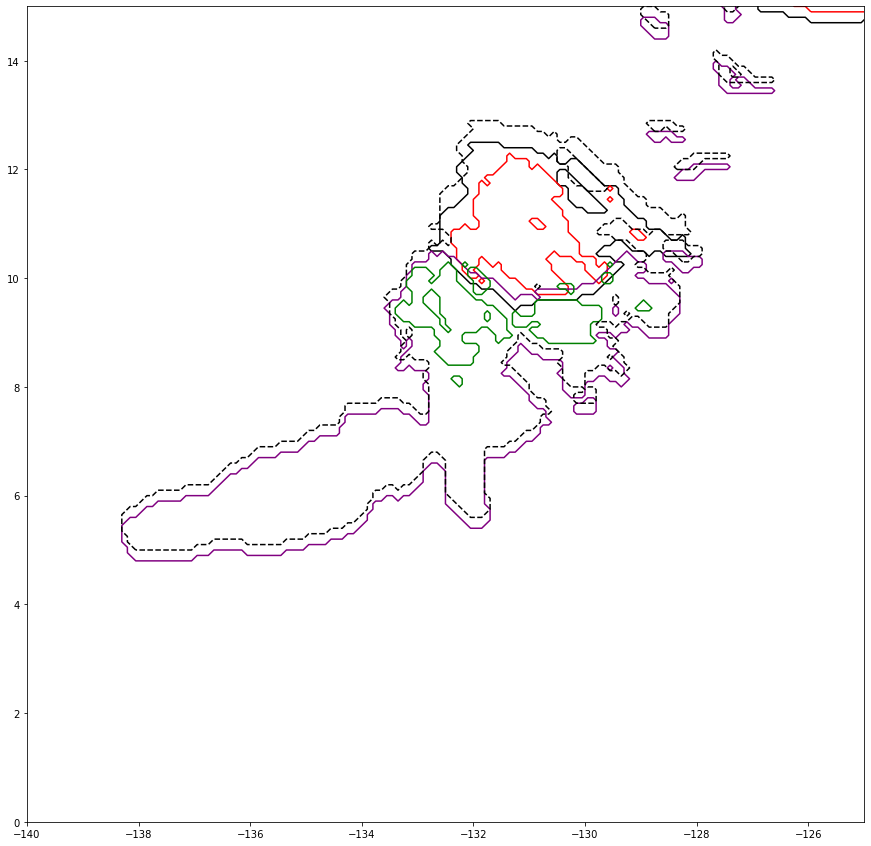

In [49]:
plt.figure(figsize=(15, 15))
mask_contour(mcs_shield, offset=-0.1, colors='k')
mask_contour(mcs_core, colors='r')
mask_contour(cloud_shield, offset=0.1, colors='purple')
mask_contour(cloud_core, offset=0.2, colors='g')
mask_contour(env, offset=0.3, colors='k', linestyles='--')
plt.xlim((-140, -125))
plt.ylim((0, 15));